In [33]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler

# Pipeline and machine learning algorithms
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, make_scorer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor,VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [34]:
# It is your job to predict the sales price for each house. 
# For each Id in the test set, you must predict the value of the SalePrice variable. 

# Load Data and Explore

Join Train and Test set so changes are made on both

In [35]:
testdata = pd.read_csv('test.csv')
traindata = pd.read_csv('train.csv')

In [36]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [37]:
trainlen=len(traindata)
y_train = traindata['SalePrice'].values
dataset=pd.concat(objs=[traindata, testdata]).reset_index(drop=True)

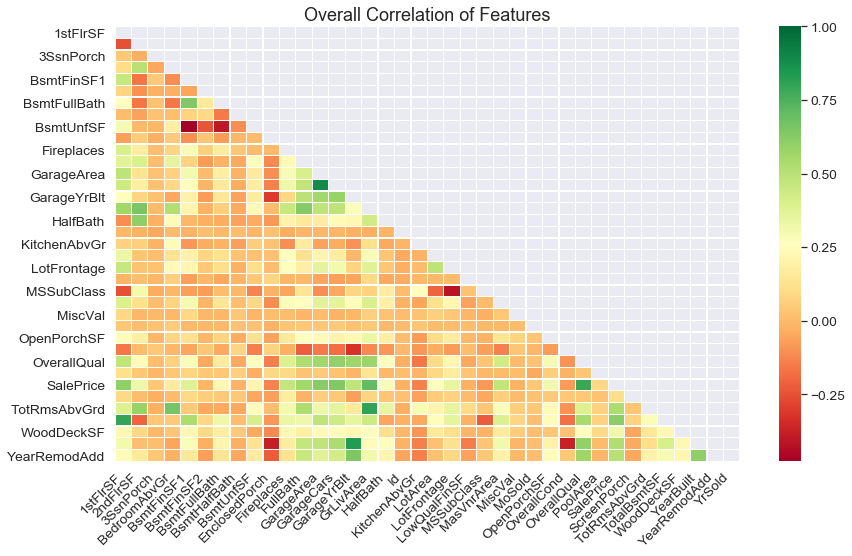

In [38]:
# Initiate correlation matrix
corrmat = dataset.corr()

# Set-up mask
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set-up figure
plt.figure(figsize=(14, 8))
plt.title('Overall Correlation of Features', fontsize=18)
ax = sns.heatmap(corrmat, mask=mask, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})

# Fix bug in heatmap to display full high rows on top and bottom
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

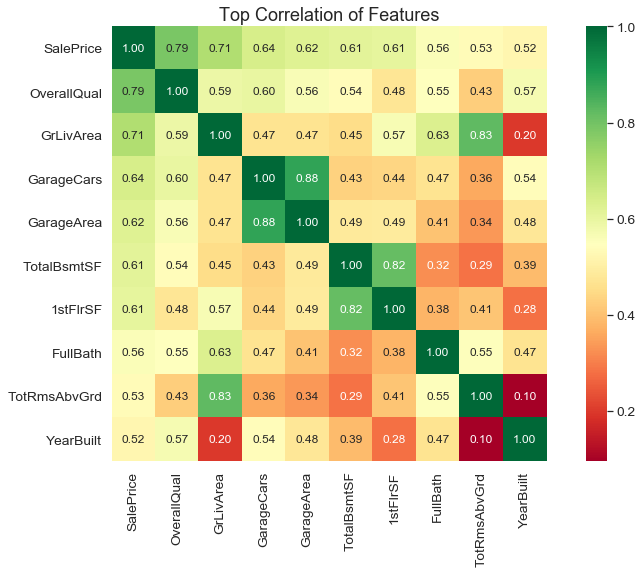

In [39]:
#saleprice correlation matrix
#set top number of variables for heatmap
k = 10 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(traindata[cols].values.T)

plt.figure(figsize=(14, 8))
plt.title('Top Correlation of Features', fontsize=18)
sns.set(font_scale=1.25)
ax = sns.heatmap(cm, cbar=True, annot=True, cmap='RdYlGn', square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [40]:
# Print details of missing data
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data.drop(['SalePrice'])

In [41]:
# Remove missing data from the top 20
dataset = dataset.drop((missing_data[missing_data['Percent'] > 0.3 ]).index,1)
missing_data.drop(missing_data[missing_data['Percent'] > 0.3 ].index , inplace=True)
missing_data.drop(missing_data[missing_data['Total'] < 1 ].index , inplace=True)
missing_data.head(20)

,Total,Percent
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageType,157,0.053786
BsmtCond,82,0.028092
BsmtExposure,82,0.028092
BsmtQual,81,0.027749
BsmtFinType2,80,0.027407


In [42]:
dataset['TotalBsmtSF'].fillna(method = 'ffill', inplace=True)
dataset['MasVnrArea']=dataset.MasVnrArea.fillna(0)
dataset['GarageYrBlt']=dataset.GarageYrBlt.fillna(1980)
dataset['Electrical']=dataset['Electrical'].fillna(method='ffill')
dataset['SaleType']=dataset['SaleType'].fillna(method='ffill')
dataset['KitchenQual']=dataset['KitchenQual'].fillna(method='ffill')
dataset['Exterior1st']=dataset['Exterior1st'].fillna(method='ffill')
dataset['Exterior2nd']=dataset['Exterior2nd'].fillna(method='ffill')
dataset['Functional']=dataset['Functional'].fillna(method='ffill')
dataset['Utilities']=dataset['Utilities'].fillna(method='ffill')
dataset['MSZoning']=dataset['MSZoning'].fillna(method='ffill')

In [43]:
#Categorical missing values
for row in missing_data.iterrows():
    if dataset[row[0]].dtype == 'object':
        dataset[row[0]] = dataset[row[0]].fillna("None")

In [44]:
#Numerical missing values
for row in missing_data.iterrows():
    if dataset[row[0]].dtype != 'object':
        dataset[row[0]] = dataset[row[0]].fillna(0)

In [45]:
# Print details of missing data
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data.drop(['SalePrice'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


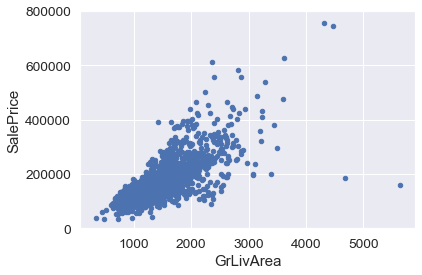

In [46]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([traindata['SalePrice'], traindata[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


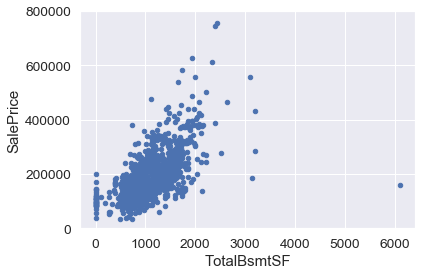

In [47]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([traindata['SalePrice'], traindata[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

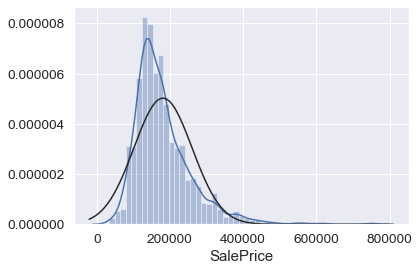

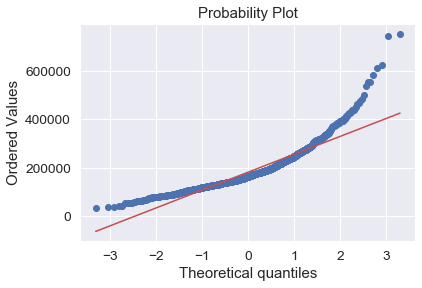

In [48]:
# histogram and normal probability plot
# in case of positive skewness, log transformations usually works well
sns.distplot(traindata['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(traindata['SalePrice'], plot=plt)

In [49]:
#applying log transformation to training data
traindata['SalePrice'] = np.log(traindata['SalePrice'])

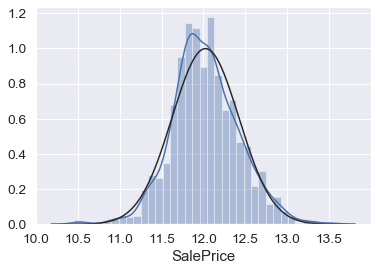

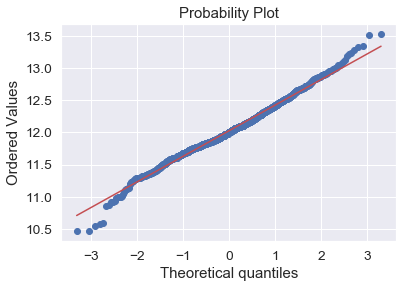

In [50]:
# histogram and normal probability plot
# in case of positive skewness, log transformations usually works well
sns.distplot(traindata['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(traindata['SalePrice'], plot=plt)

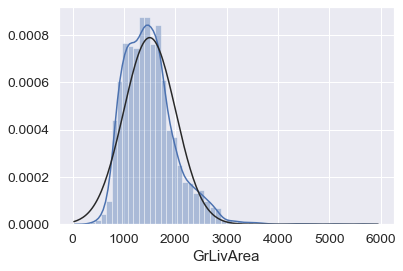

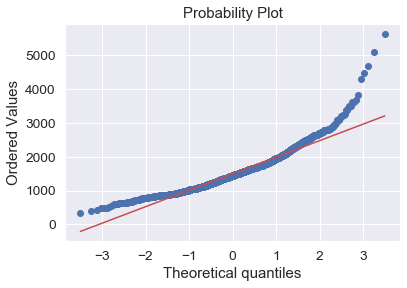

In [51]:
#histogram and normal probability plot
sns.distplot(dataset['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(dataset['GrLivArea'], plot=plt)

In [52]:
#data transformation
dataset['GrLivArea'] = np.log(dataset['GrLivArea'])

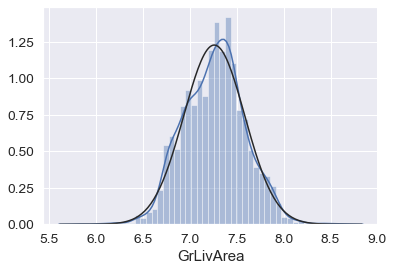

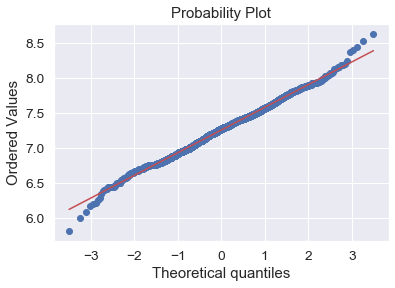

In [53]:
#histogram and normal probability plot
sns.distplot(dataset['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(dataset['GrLivArea'], plot=plt)

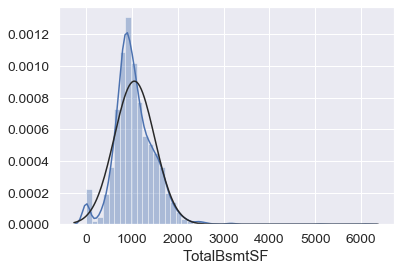

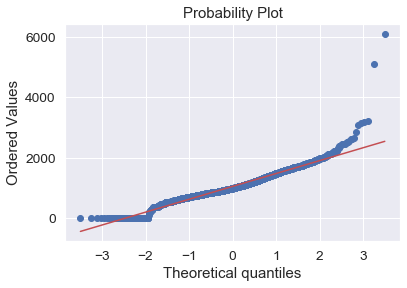

In [54]:
#histogram and normal probability plot
sns.distplot(dataset['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(dataset['TotalBsmtSF'], plot=plt)

In [55]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
dataset['HasBsmt'] = pd.Series(len(dataset['TotalBsmtSF']), index=dataset.index)
dataset['HasBsmt'] = 0 
dataset.loc[dataset['TotalBsmtSF']>0,'HasBsmt'] = 1

In [56]:
#transform data
dataset.loc[dataset['HasBsmt']==1,'TotalBsmtSF'] = np.log(dataset['TotalBsmtSF'])

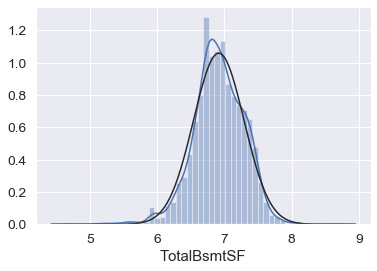

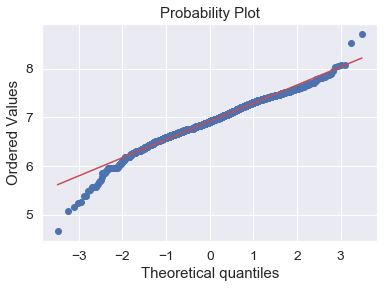

In [57]:
#histogram and normal probability plot
sns.distplot(dataset[dataset['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(dataset[dataset['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

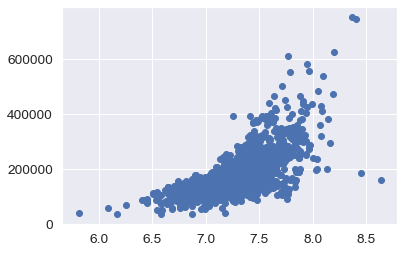

In [58]:
#scatter plot
plt.scatter(dataset['GrLivArea'], dataset['SalePrice']);

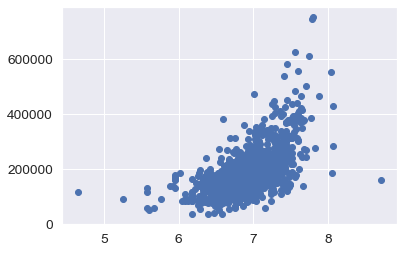

In [59]:
# scatter plot 
# by ensuring normality in some variables, we solved the homoscedasticity problem.
plt.scatter(dataset[dataset['TotalBsmtSF']>0]['TotalBsmtSF'], dataset[dataset['TotalBsmtSF']>0]['SalePrice']);

In [60]:
fillcols = list(dataset.columns[dataset.isnull().any()])
for column in fillcols:
    if column != 'SalePrice':
        dataset[column].fillna(method = 'ffill', inplace=True)

In [61]:
#convert categorical variable into dummy
dataset = pd.get_dummies(dataset)

# Separate train dataset and test dataset

In [62]:
train = dataset[:trainlen]
test = dataset[trainlen:]

In [63]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 282 entries, 1stFlrSF to Utilities_NoSeWa
dtypes: float64(13), int64(26), uint8(243)
memory usage: 1.5 MB


In [64]:
train

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
0,856,854,0,3,706.0,0.0,1.0,0.0,150.0,0,...,0,0,0,0,0,1,0,1,1,0
1,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,0,...,0,0,0,0,0,1,0,1,1,0
2,920,866,0,3,486.0,0.0,1.0,0.0,434.0,0,...,0,0,0,0,0,1,0,1,1,0
3,961,756,0,3,216.0,0.0,1.0,0.0,540.0,272,...,0,0,0,0,0,1,0,1,1,0
4,1145,1053,0,4,655.0,0.0,1.0,0.0,490.0,0,...,0,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694,0,3,0.0,0.0,0.0,0.0,953.0,0,...,0,0,0,0,0,1,0,1,1,0
1456,2073,0,0,3,790.0,163.0,1.0,0.0,589.0,0,...,0,0,0,0,0,1,0,1,1,0
1457,1188,1152,0,4,275.0,0.0,0.0,0.0,877.0,0,...,0,0,0,0,0,1,0,1,1,0
1458,1078,0,0,2,49.0,1029.0,1.0,0.0,0.0,112,...,0,0,0,0,0,1,0,1,1,0


In [65]:
# Set up feature and target variables in train set, and remove Passenger ID from test set
X_test = test
X_train = train

In [66]:
X_train = X_train.drop('SalePrice', axis=1)
X_test = X_test.drop('SalePrice', axis=1)

# Round 1: Initial models

In [67]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [68]:
xgbreg = XGBRegressor({'n_estimators': 5000,
                            'subsample': 1,
                            'min_child_weight':3,
                            'gamma':0.25,
                            'objective': 'reg:squarederror','eval_matric':'rmse'})
parameters = {'learning_rate': [0.01, 0.02],
             'max_depth': [i for i in range(10,11)],'seed':[20,19,18]}
xgb_reg = GridSearchCV(estimator=xgbreg, param_grid=parameters, cv=5, n_jobs=-1).fit(X_train, y_train)

[16:21:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [69]:
print("Best parameters set:", xgb_reg.best_params_)

Best parameters set: {'learning_rate': 0.02, 'max_depth': 10, 'seed': 20}


In [70]:
xgb_reg_y_pred = xgb_reg.predict(X_test)
xgb_reg_y_pred

array([110034.945, 131577.47 , 157665.86 , ..., 133483.81 ,  99111.305,
       182842.72 ], dtype=float32)

In [74]:
xgb_reg_y_pred

array([110034.945, 131577.47 , 157665.86 , ..., 133483.81 ,  99111.305,
       182842.72 ], dtype=float32)

In [75]:
solution = pd.DataFrame({'Id':test.Id, 'SalePrice':xgb_reg_y_pred})
solution.to_csv('DSKHouseprice.csv', index=False)

In [76]:
len(xgb_reg_y_pred)

1459

# Review the best performing Model for feature importance

Id,SalePrice
1461,169277.0524984
1462,187758.393988768
1463,183583.683569555
1464,179317.47751083
1465,150730.079976501
1466,177150.989247307
1467,172070.659229164
1468,175110.956519547
1469,162011.698831665
1470,160726.247831419
1471,157933.279456005
1472,145291.245020389
1473,159672.017631819
1474,164167.518301885
1475,150891.638244053
1476,179460.96518734
1477,185034.62891405
1478,182352.192644656
1479,183053.458213802
1480,187823.339254278
1481,186544.114327568
1482,158230.77520516
1483,190552.829321091
1484,147183.67487199
1485,185855.300905493
1486,174350.470676986
1487,201740.620690863
1488,162986.378895754
1489,162330.199085679
1490,165845.938616539
1491,180929.622876974
1492,163481.501519718
1493,187798.076714233
1494,198822.198942566
1495,194868.409899858
1496,152605.298564403
1497,147797.702836811
1498,150521.96899297
1499,146991.630153739
1500,150306.307814534
1501,151164.372534604
1502,151133.706960953
1503,156214.042540726
1504,171992.760735142
1505,173214.912549738
1506,

# Review next performing model for feature importance

# Feature selection

In [ ]:
n_jobs=-1